In [728]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.circuit.library import QFT

def int_to_bits(a, num_bits=None):
    bits = [(a >> i) & 1 for i in range(num_bits or a.bit_length())]
    return bits  # LSB first

def remove_leading_0s(bits):
    first_one = next((i for i, b in enumerate(bits) if b), len(bits))
    return bits[first_one:]

def add_classically_controlled_X(circuit, qs, bit):
    if bit:
        for q in qs:
            circuit.x(q)

def addConstant(qubit_count, a):
    if a == 0:
        return QuantumCircuit(qubit_count)
    
    a_bits = int_to_bits(a, num_bits=qubit_count)
    a_bits = remove_leading_0s(a_bits)
    bit_count = len(a_bits)
    offset = qubit_count - bit_count  # number of new LSB qubits to prepend

    if bit_count == 1:
        qc = QuantumCircuit(qubit_count)
        qc.x(qubit_count-1)
        return qc

    adderCircuit = addConstantClean(a_bits, bit_count)

    new_data = QuantumRegister(qubit_count, 'data')
    anc      = AncillaRegister(bit_count - 2, 'anc')
    result   = QuantumCircuit(new_data, anc, name=f"+{int(''.join(map(str, a_bits)), 2)}")

    qubit_map = [new_data[offset + i] for i in range(bit_count)] + list(anc)
    result.compose(adderCircuit, qubits=qubit_map, inplace=True)

    return result

def addConstantClean(a_bits, qubit_count):
    data = QuantumRegister(qubit_count, 'data')
    anc  = AncillaRegister(qubit_count - 2, 'anc')
    qc   = QuantumCircuit(data, anc, name=f"+{int(''.join(map(str, a_bits)), 2)}")

    add_classically_controlled_X(qc, [data[0], data[1]], a_bits[1])
    qc.ccx(data[0], data[1], anc[0])

    add_classically_controlled_X(qc, [anc[0]], a_bits[1]^a_bits[2])
    add_classically_controlled_X(qc, [data[2]], a_bits[2])
    qc.ccx(anc[0], data[2], anc[1])

    add_classically_controlled_X(qc, [anc[1]], a_bits[2]^a_bits[3])
    add_classically_controlled_X(qc, [data[3]], a_bits[3])
    qc.ccx(anc[1], data[3], anc[2])

    add_classically_controlled_X(qc, [anc[2]], a_bits[3]^a_bits[4])
    add_classically_controlled_X(qc, [data[4]], a_bits[4])
    qc.ccx(anc[2], data[4], anc[3])

    add_classically_controlled_X(qc, [anc[3]], a_bits[4]^a_bits[5])
    add_classically_controlled_X(qc, [data[5]], a_bits[5])
    qc.ccx(anc[3], data[5], anc[4])

    add_classically_controlled_X(qc, [anc[4]], a_bits[5])
    qc.cx(anc[4], data[6])
    add_classically_controlled_X(qc, [anc[4]], a_bits[5])

    qc.ccx(anc[3], data[5], anc[4])
    add_classically_controlled_X(qc, [data[5], anc[3]], a_bits[5])

    qc.cx(anc[3], data[5])
    add_classically_controlled_X(qc, [anc[3]], a_bits[4])

    qc.ccx(anc[2], data[4], anc[3])
    add_classically_controlled_X(qc, [anc[2], data[4]], a_bits[4])

    qc.cx(anc[2], data[4])
    add_classically_controlled_X(qc, [anc[2]], a_bits[3])

    qc.ccx(anc[1], data[3], anc[2])
    add_classically_controlled_X(qc, [anc[1], data[3]], a_bits[3])

    qc.cx(anc[1], data[3])
    add_classically_controlled_X(qc, [anc[1]], a_bits[2])

    qc.ccx(anc[0], data[2], anc[1])
    add_classically_controlled_X(qc, [anc[0], data[2]], a_bits[2])

    qc.cx(anc[0], data[2])
    add_classically_controlled_X(qc, [anc[0]], data[1])

    qc.ccx(data[0], data[1], anc[0])
    add_classically_controlled_X(qc, [data[0], data[1]], data[1])

    qc.cx(data[0], data[1])

    qc.x(data[0])
    add_classically_controlled_X(qc, [data[1]], a_bits[1])
    add_classically_controlled_X(qc, [data[2]], a_bits[2])
    add_classically_controlled_X(qc, [data[3]], a_bits[3])
    add_classically_controlled_X(qc, [data[4]], a_bits[4])
    add_classically_controlled_X(qc, [data[5]], a_bits[5])
    add_classically_controlled_X(qc, [data[6]], a_bits[6])

    return qc

def addConstant_dagger(qubit_count, a):
    return addConstant(qubit_count, a).inverse()

def add_constant_qft(n_qubits: int, c: int, ommitLastQft: bool) -> QuantumCircuit:
    """Returns a circuit that maps |x⟩ → |(x + c) mod 2^n⟩."""
    qc = QuantumCircuit(n_qubits, name=f"+{c}")
    qc.append(QFT(n_qubits, do_swaps=False), range(n_qubits))
    for k in range(n_qubits):
        angle = 2 * np.pi * c / (2 ** (k + 1))
        qc.p(angle, k)          # P(θ)|0⟩=|0⟩, P(θ)|1⟩=e^{iθ}|1⟩

    if not ommitLastQft:
        qc.append(QFT(n_qubits, do_swaps=False, inverse=True), range(n_qubits))

    return qc

def add_constant_qft_dagger(n_qubits: int, c: int, ommitFirstQft: bool = False) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits, name=f"+{c}")
    if not ommitFirstQft:
        qc.append(QFT(n_qubits, do_swaps=False), range(n_qubits))
    for k in range(n_qubits):
        angle = -2 * np.pi * c / (2 ** (k + 1))
        qc.p(angle, k)          # P(θ)|0⟩=|0⟩, P(θ)|1⟩=e^{iθ}|1⟩

    qc.append(QFT(n_qubits, do_swaps=False, inverse=True), range(n_qubits))
    
    return qc

def prepare_sto_state(n_qubits: int, a: float) -> QuantumCircuit:
    """Returns a circuit that prepares the state |ψ⟩ = N · Σ e^(-a·|i|) |i⟩."""
    qc = QuantumCircuit(n_qubits)
    last_qubit = n_qubits - 1

    qc.h(last_qubit)

    b = a
    for i in range(n_qubits-1):
        theta = 2 * np.arctan(np.exp(b))
        qc.cry(theta, last_qubit, i)
        b = b * 2
    qc.x(last_qubit)

    b = a
    for i in range(n_qubits-1):
        theta = 2 * np.arctan(np.exp(-b))
        qc.cry(theta, last_qubit, i)
        b = b * 2

    qc.x(last_qubit)

    return qc

def prepare_sto_state_dagger(n_qubits: int, a: float) -> QuantumCircuit:
    """Returns the adjoint of prepare_sto_state."""
    qc = QuantumCircuit(n_qubits)
    last_qubit = n_qubits - 1

    qc.x(last_qubit)

    b = a
    for i in range(n_qubits-1):
        theta = 2 * np.arctan(np.exp(-b))
        qc.cry(-theta, last_qubit, i)
        b = b * 2
        
    qc.x(last_qubit)

    b = a
    for i in range(n_qubits-1):
        theta = 2 * np.arctan(np.exp(b))
        qc.cry(-theta, last_qubit, i)
        b = b * 2

    qc.h(last_qubit)
    return qc


def sto(n_qubits: int, a: float, center: int) -> QuantumCircuit:
    """Returns a circuit that prepares the state |ψ⟩ = N · Σ e^(-a·|i-center|) |i⟩.
    The returned circuit has n_qubits data qubits followed by the ancilla qubits
    required by addConstant (all initialised and returned to |0⟩)."""
    adder   = addConstant(n_qubits, center)
    n_total = adder.num_qubits   # data + ancilla
    n_anc   = n_total - n_qubits

    qc = QuantumCircuit(n_total)
    # State preparation acts only on the data qubits (first n_qubits)
    qc.compose(prepare_sto_state(n_qubits, a), qubits=list(range(n_qubits)), inplace=True)
    # Adder acts on all qubits (data + ancilla)
    qc.compose(adder, qubits=list(range(n_total)), inplace=True)

    return qc


def sto_dagger(n_qubits: int, a: float, center: int) -> QuantumCircuit:
    """Returns the adjoint of sto.
    The returned circuit has n_qubits data qubits followed by the ancilla qubits
    required by addConstant_dagger (all initialised and returned to |0⟩)."""
    adder_dag = addConstant_dagger(n_qubits, center)
    n_total   = adder_dag.num_qubits
    n_anc     = n_total - n_qubits

    qc = QuantumCircuit(n_total)
    # Inverse adder acts on all qubits first
    qc.compose(adder_dag, qubits=list(range(n_total)), inplace=True)
    # Inverse state preparation acts only on the data qubits
    qc.compose(prepare_sto_state_dagger(n_qubits, a), qubits=list(range(n_qubits)), inplace=True)

    return qc


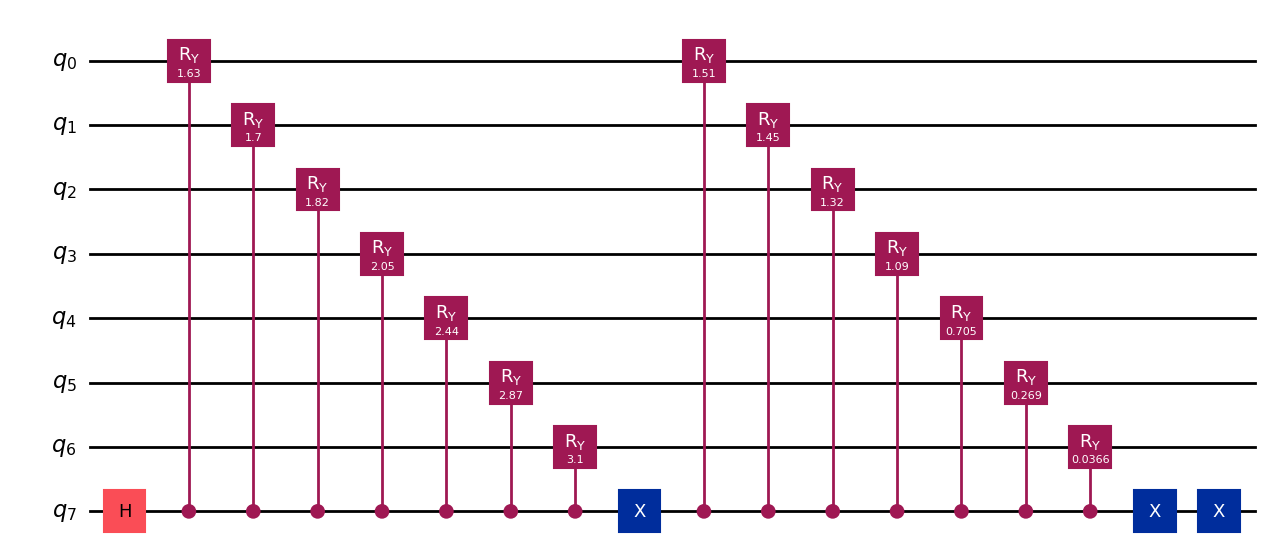

In [729]:
# Decaying exponential state: |ψ⟩ = N · Σ e^(-a·i) |i⟩  for i = 0 … 2^4-1
a = 1  # decay constant
n_qubits = 8
max_range = 16

scale = max_range / (2 ** n_qubits)
scaled_a = a * scale

center1 = 2 ** (n_qubits - 1)
center2 = 2 ** (n_qubits - 1) + 22

qc = sto(n_qubits, scaled_a, center1)
# qc.compose(sto_dagger(n_qubits, scaled_a, center2), inplace=True)

qc.draw('mpl', style='iqp')

# print(center1)
# print(center2)

In [730]:
# Simulate the statevector using Qiskit's local statevector simulator
sv = Statevector(qc)

# sto() appends ancilla qubits; extract the data-register amplitudes.
# Since ancilla are |0⟩ throughout, all amplitude is in indices 0..2^n_qubits-1.
data_amps = sv.data[:2**n_qubits]

print("Statevector amplitudes (|basis⟩ : amplitude):")
for i, amp in enumerate(data_amps):
    basis = format(i, f'0{n_qubits}b')
    if abs(amp) > 1e-6:
        print(f"  |{basis}⟩ : {amp:.4f}  (prob = {abs(amp)**2:.4f})")


Statevector amplitudes (|basis⟩ : amplitude):
  |00000000⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00000001⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00000010⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00000011⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00000100⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00000101⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00000110⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00000111⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00001000⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |00001001⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00001010⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00001011⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00001100⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00001101⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00001110⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00001111⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00010000⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |00010001⟩ : 0.0003+0.0000j  (prob = 0.0000)
  |00010010⟩ : 0.0003+0.0000j  (prob = 0.0000)
  |00010011⟩ : 0.0003+0.0000j  (prob = 0.0000)
  |00010100⟩ :

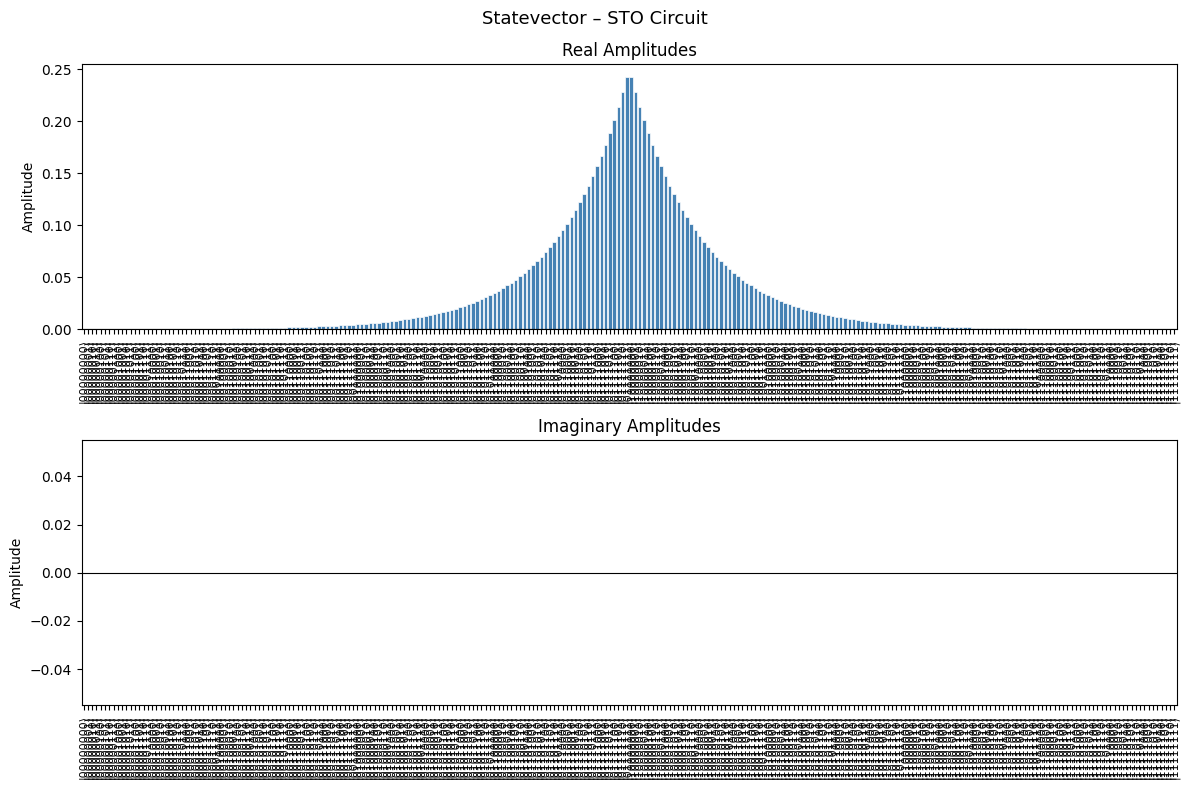

In [731]:
# Visualize statevector: two vertical bar charts stacked (real on top, imaginary below)
n_states = 2 ** n_qubits
basis_labels = [format(i, f'0{n_qubits}b') for i in range(n_states)]
real_parts = data_amps.real
imag_parts = data_amps.imag

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Statevector – STO Circuit", fontsize=13)

x = np.arange(n_states)

ax1.bar(x, real_parts, color='steelblue', edgecolor='white', linewidth=0.5)
ax1.axhline(0, color='black', linewidth=0.8)
ax1.set_title("Real Amplitudes")
ax1.set_xticks(x)
ax1.set_xticklabels([f'|{b}⟩' for b in basis_labels], rotation=90, fontsize=8)
ax1.set_ylabel("Amplitude")
ax1.set_xlim(-0.5, n_states - 0.5)

ax2.bar(x, imag_parts, color='coral', edgecolor='white', linewidth=0.5)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_title("Imaginary Amplitudes")
ax2.set_xticks(x)
ax2.set_xticklabels([f'|{b}⟩' for b in basis_labels], rotation=90, fontsize=8)
ax2.set_ylabel("Amplitude")
ax2.set_xlim(-0.5, n_states - 0.5)

plt.tight_layout()
plt.show()


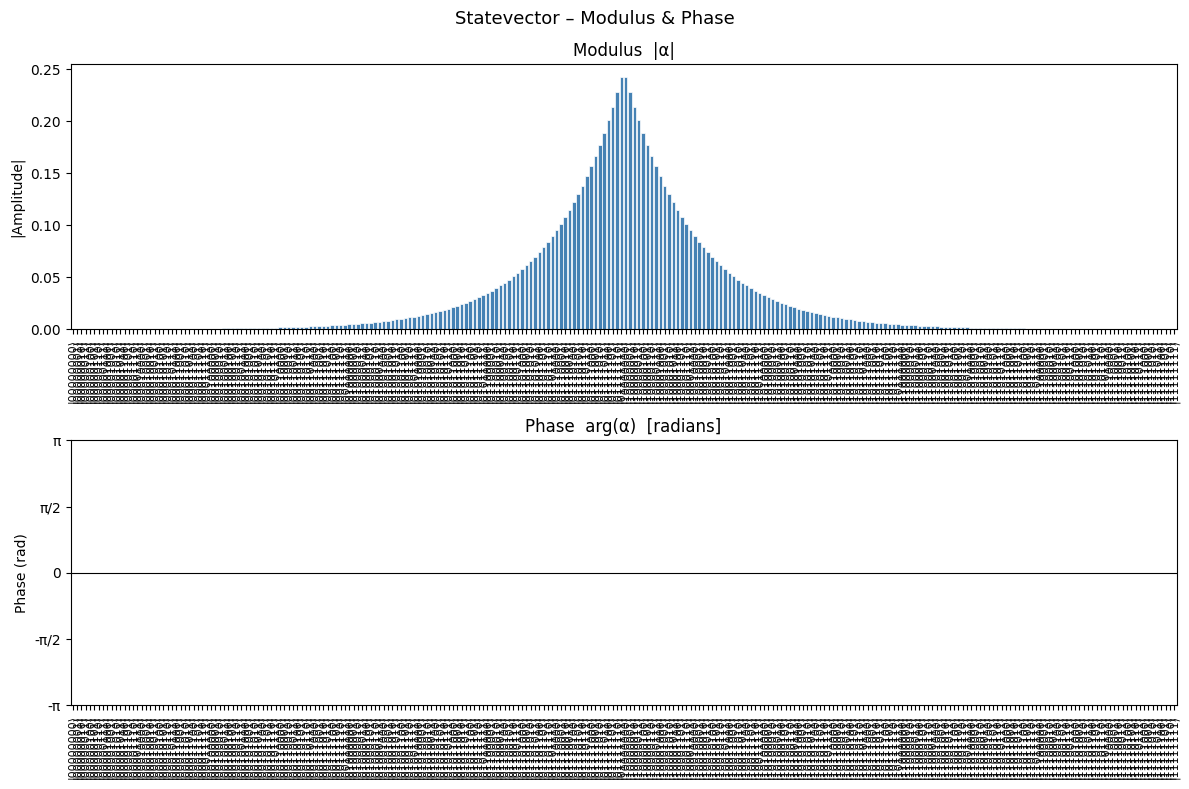

In [732]:
# Visualize statevector: modulus and phase stacked vertically
modulus = np.abs(data_amps)
phase = np.angle(data_amps)   # radians in (-π, π]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Statevector – Modulus & Phase", fontsize=13)

x = np.arange(n_states)
tick_labels = [f'|{b}⟩' for b in basis_labels]

ax1.bar(x, modulus, color='steelblue', edgecolor='white', linewidth=0.5)
ax1.set_title("Modulus  |α|")
ax1.set_xticks(x)
ax1.set_xticklabels(tick_labels, rotation=90, fontsize=8)
ax1.set_ylabel("|Amplitude|")
ax1.set_xlim(-0.5, n_states - 0.5)
ax1.set_ylim(bottom=0)

ax2.bar(x, phase, color='darkorange', edgecolor='white', linewidth=0.5)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_title("Phase  arg(α)  [radians]")
ax2.set_xticks(x)
ax2.set_xticklabels(tick_labels, rotation=90, fontsize=8)
ax2.set_ylabel("Phase (rad)")
ax2.set_xlim(-0.5, n_states - 0.5)
ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax2.set_yticklabels(['-π', '-π/2', '0', 'π/2', 'π'])

plt.tight_layout()
plt.show()


Measurement results (1024 shots):
  |00101111⟩ :    1  
  |01000111⟩ :    1  
  |01001010⟩ :    1  
  |01010010⟩ :    1  
  |01011001⟩ :    1  
  |01011100⟩ :    1  
  |01011101⟩ :    1  
  |01100000⟩ :    1  
  |01100001⟩ :    5  
  |01100010⟩ :    1  
  |01100011⟩ :    2  
  |01100101⟩ :    1  
  |01100110⟩ :    1  
  |01100111⟩ :    3  
  |01101000⟩ :    1  
  |01101001⟩ :    3  
  |01101010⟩ :    3  
  |01101011⟩ :    5  
  |01101100⟩ :    3  
  |01101101⟩ :    8  
  |01101110⟩ :    6  
  |01101111⟩ :    8  
  |01110000⟩ :    7  
  |01110001⟩ :   12  
  |01110010⟩ :   12  
  |01110011⟩ :   12  
  |01110100⟩ :   16  
  |01110101⟩ :   22  
  |01110110⟩ :   22  
  |01110111⟩ :   22  
  |01111000⟩ :   19  
  |01111001⟩ :   37  █
  |01111010⟩ :   30  █
  |01111011⟩ :   30  █
  |01111100⟩ :   42  █
  |01111101⟩ :   51  █
  |01111110⟩ :   55  ██
  |01111111⟩ :   61  ██
  |10000000⟩ :   52  ██
  |10000001⟩ :   70  ██
  |10000010⟩ :   49  █
  |10000011⟩ :   35  █
  |10000100⟩ :   37  █
  |1

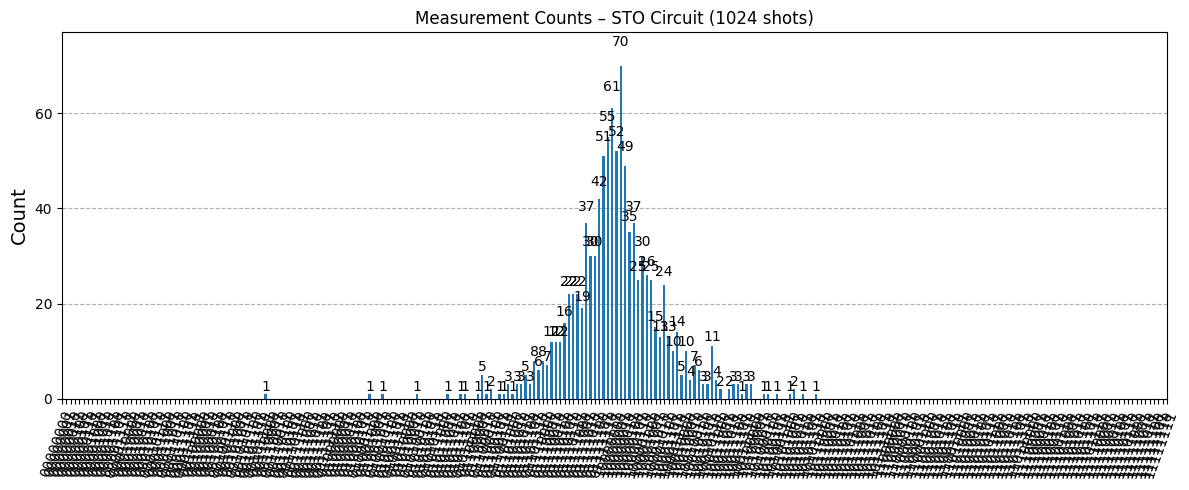

In [733]:
# Sample the data-register statevector to get measurement counts
# Build a reduced Statevector from the data-register amplitudes only
data_sv = Statevector(data_amps)

shots = 1024
counts = data_sv.sample_counts(shots)

print(f"Measurement results ({shots} shots):")
for state in sorted(counts.keys()):
    bar = '█' * int(counts[state] / shots * 40)
    print(f"  |{state}⟩ : {counts[state]:4d}  {bar}")

# Include all 2^n basis states (zeros for unobserved states)
all_basis = [format(i, f'0{n_qubits}b') for i in range(2 ** n_qubits)]
counts_full = {b: counts.get(b, 0) for b in all_basis}

# Plot histogram of sample counts
fig = plot_histogram(
    counts_full,
    title=f"Measurement Counts – STO Circuit ({shots} shots)",
    figsize=(12, 5),
    bar_labels=True,
)
fig.tight_layout()
display(fig)


In [734]:
# Decaying exponential state: |ψ⟩ = N · Σ e^(-a·i) |i⟩  for i = 0 … 2^4-1
a = 1  # decay constant
n_qubits = 8
max_range = 16

scale = max_range / (2 ** n_qubits)
scaled_a = a * scale

center1 = 2 ** (n_qubits - 1)
center2 = 2 ** (n_qubits - 1) + 22

# sto / sto_dagger may return different total qubit counts when the two centers
# require different numbers of ancilla qubits.  Build the overlap on a circuit
# wide enough for both, composing each sub-circuit on its own qubit slice.
qc1     = sto(n_qubits, scaled_a, center1)
qc2_dag = sto_dagger(n_qubits, scaled_a, center2)
n_total = max(qc1.num_qubits, qc2_dag.num_qubits)

qc = QuantumCircuit(n_total)
qc.compose(qc1,     qubits=list(range(qc1.num_qubits)),     inplace=True)
qc.compose(qc2_dag, qubits=list(range(qc2_dag.num_qubits)), inplace=True)

sv_overlap = Statevector(qc)
zero_key = '0' * n_total                    # all qubits (data + ancilla) must be |0⟩
S_exact = sv_overlap.data[0].real           # amplitude of |0…0⟩  (purely real)
P_exact = abs(sv_overlap.data[0])**2        # = S²

print(f"Exact (statevector) amplitude  ⟨0|circuit|0⟩ = {S_exact:.6f}")
print(f"Exact (statevector) |S|²       P(|0…0⟩)      = {P_exact:.6f}")
print(f"Exact S = √P                                  = {np.sqrt(P_exact):.6f}")
print()

shots = 9000
counts_ov = sv_overlap.sample_counts(shots)
p_zero_sampled = counts_ov.get(zero_key, 0) / shots
S_sampled = np.sqrt(p_zero_sampled)

print(f"Sampler ({shots} shots):")
print(f"  Counts for |{zero_key}⟩  = {counts_ov.get(zero_key, 0)}")
print(f"  P(|0…0⟩)  = {p_zero_sampled:.6f}")
print(f"  S = √P    = {S_sampled:.6f}")
print()
print(f"Shot noise:           {abs(S_sampled - S_exact):.4f}  ({abs(S_sampled - S_exact)/S_exact*100:.2f} %)")


Exact (statevector) amplitude  ⟨0|circuit|0⟩ = 0.600721
Exact (statevector) |S|²       P(|0…0⟩)      = 0.360865
Exact S = √P                                  = 0.600721

Sampler (9000 shots):
  Counts for |0000000000000⟩  = 3261
  P(|0…0⟩)  = 0.362333
  S = √P    = 0.601941

Shot noise:           0.0012  (0.20 %)


In [735]:
# ── Overlap circuit:  O₂† · O₁ · |0⟩ ────────────────────────────────────────
# S = ⟨ψ₁|ψ₂⟩ = ⟨0|O₁†O₂|0⟩  ⟹  circuit = O₁† O₂ (or equivalently O₂† O₁)
# P(|0…0⟩) = |S|²   →   S = √P  (real, positive wavefunctions)

# center1 effective max is at index 127.5  → physical position 127.5 * dx = 7.96875
# center2 = 150: effective max at 149.5    → physical position 149.5 * dx = 9.34375
# separation d = (149.5 - 127.5) * dx = 22 * (1/16) = 1.375 a.u.  ≈ 1.4 a.u.

center2_overlap = 150
d_grid  = (149.5 - 127.5) * scale          # effective physical separation
S_cont  = (1 + a * d_grid) * np.exp(-a * d_grid)   # continuous benchmark

# Build the overlap circuit; sto/sto_dagger now include ancilla qubits so the
# two sub-circuits may differ in size depending on center.  Allocate a circuit
# wide enough for both and compose each onto its own qubit slice.
qc_sto      = sto(n_qubits, scaled_a, center1)
qc_sto_dag  = sto_dagger(n_qubits, scaled_a, center2_overlap)
n_ov_total  = max(qc_sto.num_qubits, qc_sto_dag.num_qubits)
zero_key_ov = '0' * n_ov_total

qc_overlap = QuantumCircuit(n_ov_total)
qc_overlap.compose(qc_sto,     qubits=list(range(qc_sto.num_qubits)),     inplace=True)
qc_overlap.compose(qc_sto_dag, qubits=list(range(qc_sto_dag.num_qubits)), inplace=True)

# ── Exact overlap via statevector (ground truth) ──────────────────────────────
sv_overlap = Statevector(qc_overlap)
S_exact = sv_overlap.data[0].real      # amplitude of |0…0⟩  (purely real)
P_exact = abs(sv_overlap.data[0])**2  # = S²

print(f"Effective separation    d  = {d_grid:.4f} a.u.  (closest to 1.4 a.u.)")
print(f"Continuous benchmark    S  = {S_cont:.6f}")
print()
print(f"Exact (statevector) amplitude  ⟨0|circuit|0⟩ = {S_exact:.6f}")
print(f"Exact (statevector) |S|²       P(|0…0⟩)      = {P_exact:.6f}")
print(f"Exact S = √P                                  = {np.sqrt(P_exact):.6f}")
print()

# ── Sampler estimation ────────────────────────────────────────────────────────
shots = 8192
counts_ov = sv_overlap.sample_counts(shots)
p_zero_sampled = counts_ov.get(zero_key_ov, 0) / shots
S_sampled = np.sqrt(p_zero_sampled)

print(f"Sampler ({shots} shots):")
print(f"  Counts for |{zero_key_ov}⟩  = {counts_ov.get(zero_key_ov, 0)}")
print(f"  P(|0…0⟩)  = {p_zero_sampled:.6f}")
print(f"  S = √P    = {S_sampled:.6f}")
print()
print(f"Error vs continuous:  {abs(S_sampled - S_cont):.4f}  ({abs(S_sampled - S_cont)/S_cont*100:.2f} %)")
print(f"Discretisation error: {abs(S_exact  - S_cont):.4f}  ({abs(S_exact  - S_cont)/S_cont*100:.2f} %)")
print(f"Shot noise:           {abs(S_sampled - S_exact):.4f}  ({abs(S_sampled - S_exact)/S_exact*100:.2f} %)")


Effective separation    d  = 1.3750 a.u.  (closest to 1.4 a.u.)
Continuous benchmark    S  = 0.600494

Exact (statevector) amplitude  ⟨0|circuit|0⟩ = 0.600721
Exact (statevector) |S|²       P(|0…0⟩)      = 0.360865
Exact S = √P                                  = 0.600721

Sampler (8192 shots):
  Counts for |0000000000000⟩  = 2960
  P(|0…0⟩)  = 0.361328
  S = √P    = 0.601106

Error vs continuous:  0.0006  (0.10 %)
Discretisation error: 0.0002  (0.04 %)
Shot noise:           0.0004  (0.06 %)


In [736]:
from qiskit.compiler import transpile

# ── Circuit complexity (logical) ───────────────────────────────────────────────
qc_overlap.measure_all()
print("=== Logical circuit ===")
print(f"Qubits              : {qc_overlap.num_qubits}")
print(f"Depth               : {qc_overlap.depth()}")
print(f"Gate counts         : {dict(qc_overlap.count_ops())}")

# ── Transpile to IBM's native gate set (basis: ECR, RZ, SX, X) ────────────────
# Using 'ibm_torino' topology as a representative 133-qubit Heron r1 device.
# optimization_level=3 = most aggressive optimisation Qiskit can do.
qc_t = transpile(qc_overlap, basis_gates=['ecr', 'rz', 'sx', 'x'],
                 optimization_level=3, seed_transpiler=42)

two_q = {k: v for k, v in qc_t.count_ops().items() if k == 'ecr'}
print()
print("=== After transpilation to IBM native gates (no connectivity constraint) ===")
print(f"Depth               : {qc_t.depth()}")
print(f"Gate counts         : {dict(qc_t.count_ops())}")
print(f"2-qubit gates (ECR) : {two_q.get('ecr', 0)}")
print()
print("=== Feasibility summary ===")
ecr_count = two_q.get('ecr', 0)
# Typical IBM Heron r1 2Q gate error ~ 3e-3, T1/T2 ~ 100-300 us, gate time ~ 100ns
# Rule of thumb: circuit is viable if ecr_count * error_per_ecr << 1
error_per_ecr = 3e-3
expected_fidelity = (1 - error_per_ecr) ** ecr_count
print(f"ECR count           : {ecr_count}")
print(f"Est. fidelity       : (1 - {error_per_ecr})^{ecr_count} = {expected_fidelity:.4f}")
print(f"Verdict             : {'feasible ✓' if expected_fidelity > 0.1 else 'too deep — error correction or noise mitigation needed ✗'}")


=== Logical circuit ===
Qubits              : 13
Depth               : 53
Gate counts         : {'cry': 28, 'x': 21, 'measure': 13, 'ccx': 10, 'cx': 6, 'h': 2, 'barrier': 1}

=== After transpilation to IBM native gates (no connectivity constraint) ===
Depth               : 378
Gate counts         : {'rz': 305, 'sx': 134, 'ecr': 122, 'x': 83, 'measure': 13, 'barrier': 1}
2-qubit gates (ECR) : 122

=== Feasibility summary ===
ECR count           : 122
Est. fidelity       : (1 - 0.003)^122 = 0.6931
Verdict             : feasible ✓


In [738]:
def transpile_ecr(qc):
    qc_m = qc.copy()
    qc_m.measure_all()
    qc_t = transpile(qc_m, basis_gates=['ecr', 'rz', 'sx', 'x'],
                     optimization_level=3, seed_transpiler=42)
    ops = qc_t.count_ops()
    return ops.get('ecr', 0), qc_t.depth(), qc_t.num_qubits

# ── QFT overlap, no manual cancellation ──────────────────────────────────────
def sto_qft_full(n_qubits, a, center):
    qc = QuantumCircuit(n_qubits)
    qc.compose(prepare_sto_state(n_qubits, a), inplace=True)
    qc.compose(add_constant_qft(n_qubits, center, ommitLastQft=False), inplace=True)
    return qc

def sto_dagger_qft_full(n_qubits, a, center):
    qc = QuantumCircuit(n_qubits)
    qc.compose(add_constant_qft_dagger(n_qubits, center, ommitFirstQft=False), inplace=True)
    qc.compose(prepare_sto_state_dagger(n_qubits, a), inplace=True)
    return qc

def sto_dagger_qft_cancel(n_qubits, a, center):
    qc = QuantumCircuit(n_qubits)
    qc.compose(add_constant_qft_dagger(n_qubits, center, ommitFirstQft=True), inplace=True)
    qc.compose(prepare_sto_state_dagger(n_qubits, a), inplace=True)
    return qc

qc_no_cancel = QuantumCircuit(n_qubits)
qc_no_cancel.compose(sto_qft_full(n_qubits, scaled_a, center1), inplace=True)
qc_no_cancel.compose(sto_dagger_qft_full(n_qubits, scaled_a, center2_overlap), inplace=True)

def sto_qft_cancel(n_qubits, a, center):
    """O₁ with the trailing IQFT omitted — to be cancelled by O₂†'s leading QFT."""
    qc = QuantumCircuit(n_qubits)
    qc.compose(prepare_sto_state(n_qubits, a), inplace=True)
    qc.compose(add_constant_qft(n_qubits, center, ommitLastQft=True), inplace=True)
    return qc

qc_manual_cancel = QuantumCircuit(n_qubits)
qc_manual_cancel.compose(sto_qft_cancel(n_qubits, scaled_a, center1), inplace=True)        # IQFT omitted
qc_manual_cancel.compose(sto_dagger_qft_cancel(n_qubits, scaled_a, center2_overlap), inplace=True)  # QFT omitted

# ── Toffoli/CNOT overlap (current) ────────────────────────────────────────────
qc_toff = QuantumCircuit(n_ov_total)
qc_toff.compose(qc_sto,     qubits=list(range(qc_sto.num_qubits)),     inplace=True)
qc_toff.compose(qc_sto_dag, qubits=list(range(qc_sto_dag.num_qubits)), inplace=True)

# ── Side-by-side comparison ────────────────────────────────────────────────────
cases = [
    ("QFT, no cancellation",     qc_no_cancel),
    ("QFT, manual cancellation", qc_manual_cancel),
    ("Toffoli/CNOT (new)",       qc_toff),
]

print(f"{'Approach':<30}  {'Qubits':>7}  {'ECR':>6}  {'Depth':>7}  {'Est. fidelity':>14}")
print("-" * 72)
for name, qc_c in cases:
    ecr, depth, qubits = transpile_ecr(qc_c)
    fid = (1 - 3e-3) ** ecr
    print(f"{name:<30}  {qubits:>7}  {ecr:>6}  {depth:>7}  {fid:>14.4f}")

print()
print(f"Ancilla overhead: Toffoli circuit needs {n_ov_total} qubits vs {n_qubits} for QFT.")
print("If QFT rows match → the transpiler already auto-cancels the boundary QFT/IQFT pair,")
print("so manual cancellation gives no benefit on top of what Qiskit already does.")


C:\Users\sorin\AppData\Local\Temp\ipykernel_34708\1122002408.py:121: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=False), range(n_qubits))
C:\Users\sorin\AppData\Local\Temp\ipykernel_34708\1122002408.py:127: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=False, inverse=True), range(n_qubits))
C:\Users\sorin\AppData\Local\Temp\ipykernel_34708\1122002408.py:134: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will b

Approach                         Qubits     ECR    Depth   Est. fidelity
------------------------------------------------------------------------
QFT, no cancellation                  8     135      355          0.6666
QFT, manual cancellation              8     135      354          0.6666
Toffoli/CNOT (new)                   13     122      378          0.6931

Ancilla overhead: Toffoli circuit needs 13 qubits vs 8 for QFT.
If QFT rows match → the transpiler already auto-cancels the boundary QFT/IQFT pair,
so manual cancellation gives no benefit on top of what Qiskit already does.
